# DenseNet-121 fine-tuning, CIFAR-10, PyTorch

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
%env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
# %env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0, 1, 2, 3


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 4
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX 1080 Ti
Available device is cuda


In [4]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 50

#### CIFAR-10 data pre-processing

In [5]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        A.Resize(width = 224, height = 224),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Resize(width = 224, height = 224),
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [6]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [7]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 782 & len(val_loader) = 157


(781.25, 156.25)

#### DenseNet-121 pre-trained CNN architecture

In [10]:
# Load pre-trained DenseNet-121 model-
model = models.densenet121(weights = torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)

In [11]:
# Remove (2x2) pool since CIFAR-10 images are small and don't need it-
del model.features.pool0

In [12]:
# Modify output layer to have 10 instead of 1000 output neurons-
model.classifier = nn.Linear(
    in_features = 1024, out_features = num_classes,
    bias = True
)

In [13]:
# Sanity check-
model.classifier

Linear(in_features=1024, out_features=10, bias=True)

In [ ]:
# Place model on GPU-
# model = model.to(device)

#### Multi-GPU PyTorch training

Using Data Parallelism

To use data parallelism with PyTorch, you can use the DataParallel class. When using this class, you define your GPU IDs and initialize your network using a Module object with a DataParallel object.

```
parallel_net = nn.DataParallel(myNet, gpu_ids = [0,1,2])
```

Once defined, you can perform the standard model training steps just as you would with a standard ```nn.Module``` object. For example:

```
# performs a forward pass
predictions = parallel_net(inputs) 

# computes a loss function
loss = loss_function(predictions, labels)

# averages GPU-losses and performs a backward pass
loss.mean().backward()

optimizer.step()
```

When using this method, you need to ensure that your data is initially stored on one GPU (the “primary GPU”). You should also place your data parallel object on that same GPU. You can do this using code like the following:

```
input = input.to(0)
parallel_net = parellel_net.to(0)
```

Then, when you call your object it can split your dataset into batches that are distributed across your defined GPUs. Once the operations are complete, the outputs are aggregated on the primary GPU.

[Reference](https://www.run.ai/guides/multi-gpu/pytorch-multi-gpu-4-techniques-explained)

In [14]:
# Use specific GPUs for training-
parallel_net = nn.DataParallel(model, device_ids = [0, 1, 2, 3])

# Move to CUDA GPU-
parallel_net = parallel_net.to(0)

In [15]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of parameters in DenseNet-121 CNN = {tot_params}")

Total number of parameters in DenseNet-121 CNN = 6964106


In [16]:
# Define cost function-
loss = nn.CrossEntropyLoss()

# Learning rate - Observe that all parameters are being optimized-
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001, momentum = 0.9)

In [17]:
# Learning rate scheduler - Decay LR by a factor of 0.1 every 15 epochs-
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)

In [18]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(0)
            labels = labels.to(0)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(0)
                labels = labels.to(0)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [19]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [20]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = parallel_net, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = parallel_net, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.5f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    exp_lr_scheduler.step()
    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        # torch.save(model.state_dict(), "DenseNet121_best_model.pth")
        torch.save(parallel_net.module.state_dict(), "DenseNet121_best_model.pth") 
        

Validation: : 100%|████████████████████████████████| 157/157 [00:38<00:00,  4.11batch/s, val_acc=86, val_loss=0.414]



epoch: 1 training loss = 1.1345, training accuracy = 61.33%, val_loss = 0.4137, val_accuracy = 86.03% & LR = 0.00100

Saving model with highest val_acc = 86.03%



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.10batch/s, val_acc=90.8, val_loss=0.272]



epoch: 2 training loss = 0.5848, training accuracy = 80.29%, val_loss = 0.2718, val_accuracy = 90.76% & LR = 0.00100

Saving model with highest val_acc = 90.76%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.20batch/s, val_acc=92.2, val_loss=0.241]



epoch: 3 training loss = 0.4672, training accuracy = 84.01%, val_loss = 0.2408, val_accuracy = 92.19% & LR = 0.00100

Saving model with highest val_acc = 92.19%



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.05batch/s, val_acc=93.2, val_loss=0.203]



epoch: 4 training loss = 0.3967, training accuracy = 86.36%, val_loss = 0.2026, val_accuracy = 93.16% & LR = 0.00100

Saving model with highest val_acc = 93.16%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.16batch/s, val_acc=93.9, val_loss=0.183]



epoch: 5 training loss = 0.3583, training accuracy = 87.91%, val_loss = 0.1826, val_accuracy = 93.92% & LR = 0.00100

Saving model with highest val_acc = 93.92%



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  3.96batch/s, val_acc=93.9, val_loss=0.183]



epoch: 6 training loss = 0.3250, training accuracy = 88.88%, val_loss = 0.1829, val_accuracy = 93.94% & LR = 0.00100

Saving model with highest val_acc = 93.94%



Validation: : 100%|██████████████████████████████| 157/157 [00:36<00:00,  4.25batch/s, val_acc=94.1, val_loss=0.173]



epoch: 7 training loss = 0.2942, training accuracy = 89.93%, val_loss = 0.1732, val_accuracy = 94.12% & LR = 0.00100

Saving model with highest val_acc = 94.12%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.17batch/s, val_acc=94.5, val_loss=0.167]



epoch: 8 training loss = 0.2751, training accuracy = 90.49%, val_loss = 0.1669, val_accuracy = 94.51% & LR = 0.00100

Saving model with highest val_acc = 94.51%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.15batch/s, val_acc=94.5, val_loss=0.162]



epoch: 9 training loss = 0.2573, training accuracy = 91.39%, val_loss = 0.1615, val_accuracy = 94.55% & LR = 0.00100

Saving model with highest val_acc = 94.55%



Validation: : 100%|██████████████████████████████| 157/157 [00:36<00:00,  4.26batch/s, val_acc=94.2, val_loss=0.172]



epoch: 10 training loss = 0.2445, training accuracy = 91.74%, val_loss = 0.1720, val_accuracy = 94.17% & LR = 0.00100



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.22batch/s, val_acc=94.8, val_loss=0.157]



epoch: 11 training loss = 0.2308, training accuracy = 92.26%, val_loss = 0.1566, val_accuracy = 94.75% & LR = 0.00100

Saving model with highest val_acc = 94.75%



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.12batch/s, val_acc=95.2, val_loss=0.142]



epoch: 12 training loss = 0.2176, training accuracy = 92.57%, val_loss = 0.1425, val_accuracy = 95.18% & LR = 0.00100

Saving model with highest val_acc = 95.18%



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.09batch/s, val_acc=95.4, val_loss=0.141]



epoch: 13 training loss = 0.2079, training accuracy = 92.87%, val_loss = 0.1406, val_accuracy = 95.44% & LR = 0.00100

Saving model with highest val_acc = 95.44%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.22batch/s, val_acc=94.7, val_loss=0.161]



epoch: 14 training loss = 0.1976, training accuracy = 93.35%, val_loss = 0.1607, val_accuracy = 94.66% & LR = 0.00100



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.06batch/s, val_acc=95.1, val_loss=0.141]



epoch: 15 training loss = 0.1844, training accuracy = 93.73%, val_loss = 0.1413, val_accuracy = 95.10% & LR = 0.00100



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.23batch/s, val_acc=95.6, val_loss=0.133]



epoch: 16 training loss = 0.1532, training accuracy = 94.87%, val_loss = 0.1332, val_accuracy = 95.58% & LR = 0.00010

Saving model with highest val_acc = 95.58%



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  3.98batch/s, val_acc=95.7, val_loss=0.131]



epoch: 17 training loss = 0.1445, training accuracy = 95.21%, val_loss = 0.1309, val_accuracy = 95.73% & LR = 0.00010

Saving model with highest val_acc = 95.73%



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.24batch/s, val_acc=95.8, val_loss=0.126]



epoch: 18 training loss = 0.1381, training accuracy = 95.45%, val_loss = 0.1257, val_accuracy = 95.83% & LR = 0.00010

Saving model with highest val_acc = 95.83%



Validation: : 100%|██████████████████████████████| 157/157 [00:40<00:00,  3.89batch/s, val_acc=95.9, val_loss=0.123]



epoch: 19 training loss = 0.1355, training accuracy = 95.48%, val_loss = 0.1234, val_accuracy = 95.92% & LR = 0.00010

Saving model with highest val_acc = 95.92%



Validation: : 100%|██████████████████████████████| 157/157 [00:36<00:00,  4.25batch/s, val_acc=95.9, val_loss=0.125]



epoch: 20 training loss = 0.1307, training accuracy = 95.72%, val_loss = 0.1248, val_accuracy = 95.85% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.24batch/s, val_acc=96.1, val_loss=0.123]



epoch: 21 training loss = 0.1311, training accuracy = 95.73%, val_loss = 0.1226, val_accuracy = 96.12% & LR = 0.00010

Saving model with highest val_acc = 96.12%



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.18batch/s, val_acc=96, val_loss=0.124]



epoch: 22 training loss = 0.1293, training accuracy = 95.79%, val_loss = 0.1236, val_accuracy = 96.01% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.19batch/s, val_acc=95.8, val_loss=0.127]



epoch: 23 training loss = 0.1286, training accuracy = 95.69%, val_loss = 0.1270, val_accuracy = 95.79% & LR = 0.00010



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.18batch/s, val_acc=96, val_loss=0.124]



epoch: 24 training loss = 0.1282, training accuracy = 95.79%, val_loss = 0.1238, val_accuracy = 95.96% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.21batch/s, val_acc=95.9, val_loss=0.124]



epoch: 25 training loss = 0.1230, training accuracy = 95.95%, val_loss = 0.1239, val_accuracy = 95.87% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:41<00:00,  3.78batch/s, val_acc=95.9, val_loss=0.127]



epoch: 26 training loss = 0.1235, training accuracy = 95.88%, val_loss = 0.1267, val_accuracy = 95.90% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  3.96batch/s, val_acc=96.1, val_loss=0.123]



epoch: 27 training loss = 0.1224, training accuracy = 96.02%, val_loss = 0.1226, val_accuracy = 96.10% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.05batch/s, val_acc=95.9, val_loss=0.125]



epoch: 28 training loss = 0.1212, training accuracy = 96.02%, val_loss = 0.1252, val_accuracy = 95.85% & LR = 0.00010



Validation: : 100%|████████████████████████████████| 157/157 [00:39<00:00,  3.95batch/s, val_acc=96, val_loss=0.125]



epoch: 29 training loss = 0.1209, training accuracy = 96.11%, val_loss = 0.1249, val_accuracy = 95.99% & LR = 0.00010



Validation: : 100%|████████████████████████████████| 157/157 [00:36<00:00,  4.27batch/s, val_acc=96, val_loss=0.124]



epoch: 30 training loss = 0.1183, training accuracy = 96.12%, val_loss = 0.1244, val_accuracy = 95.95% & LR = 0.00010



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  4.01batch/s, val_acc=95.8, val_loss=0.128]



epoch: 31 training loss = 0.1132, training accuracy = 96.33%, val_loss = 0.1280, val_accuracy = 95.76% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  3.96batch/s, val_acc=96.2, val_loss=0.125]



epoch: 32 training loss = 0.1129, training accuracy = 96.35%, val_loss = 0.1246, val_accuracy = 96.19% & LR = 0.00001

Saving model with highest val_acc = 96.19%



Validation: : 100%|██████████████████████████████| 157/157 [00:39<00:00,  3.94batch/s, val_acc=95.9, val_loss=0.125]



epoch: 33 training loss = 0.1145, training accuracy = 96.27%, val_loss = 0.1251, val_accuracy = 95.91% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:38<00:00,  4.04batch/s, val_acc=95.9, val_loss=0.127]



epoch: 34 training loss = 0.1157, training accuracy = 96.20%, val_loss = 0.1266, val_accuracy = 95.88% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.20batch/s, val_acc=96.1, val_loss=0.122]



epoch: 35 training loss = 0.1129, training accuracy = 96.32%, val_loss = 0.1217, val_accuracy = 96.08% & LR = 0.00001



Validation: : 100%|████████████████████████████████| 157/157 [00:39<00:00,  4.01batch/s, val_acc=96, val_loss=0.124]



epoch: 36 training loss = 0.1146, training accuracy = 96.17%, val_loss = 0.1236, val_accuracy = 96.00% & LR = 0.00001



Validation: : 100%|███████████████████████████████| 157/157 [00:37<00:00,  4.16batch/s, val_acc=96.1, val_loss=0.12]



epoch: 37 training loss = 0.1140, training accuracy = 96.28%, val_loss = 0.1203, val_accuracy = 96.13% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.16batch/s, val_acc=95.9, val_loss=0.124]



epoch: 38 training loss = 0.1162, training accuracy = 96.26%, val_loss = 0.1239, val_accuracy = 95.92% & LR = 0.00001



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.23batch/s, val_acc=96, val_loss=0.123]



epoch: 39 training loss = 0.1136, training accuracy = 96.28%, val_loss = 0.1230, val_accuracy = 96.05% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.19batch/s, val_acc=96.1, val_loss=0.122]



epoch: 40 training loss = 0.1129, training accuracy = 96.36%, val_loss = 0.1219, val_accuracy = 96.08% & LR = 0.00001



Validation: : 100%|████████████████████████████████| 157/157 [00:38<00:00,  4.13batch/s, val_acc=96, val_loss=0.123]



epoch: 41 training loss = 0.1109, training accuracy = 96.38%, val_loss = 0.1231, val_accuracy = 96.01% & LR = 0.00001



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.14batch/s, val_acc=96, val_loss=0.124]



epoch: 42 training loss = 0.1126, training accuracy = 96.33%, val_loss = 0.1238, val_accuracy = 95.99% & LR = 0.00001



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.18batch/s, val_acc=96, val_loss=0.123]



epoch: 43 training loss = 0.1134, training accuracy = 96.28%, val_loss = 0.1229, val_accuracy = 96.01% & LR = 0.00001



Validation: : 100%|██████████████████████████████| 157/157 [00:36<00:00,  4.29batch/s, val_acc=95.9, val_loss=0.124]



epoch: 44 training loss = 0.1145, training accuracy = 96.31%, val_loss = 0.1239, val_accuracy = 95.94% & LR = 0.00001



Validation: : 100%|███████████████████████████████| 157/157 [00:38<00:00,  4.10batch/s, val_acc=96.2, val_loss=0.12]



epoch: 45 training loss = 0.1124, training accuracy = 96.34%, val_loss = 0.1200, val_accuracy = 96.20% & LR = 0.00001

Saving model with highest val_acc = 96.20%



Validation: : 100%|██████████████████████████████| 157/157 [00:36<00:00,  4.27batch/s, val_acc=95.9, val_loss=0.126]



epoch: 46 training loss = 0.1119, training accuracy = 96.41%, val_loss = 0.1260, val_accuracy = 95.88% & LR = 0.00000



Validation: : 100%|████████████████████████████████| 157/157 [00:37<00:00,  4.14batch/s, val_acc=96, val_loss=0.126]



epoch: 47 training loss = 0.1121, training accuracy = 96.32%, val_loss = 0.1262, val_accuracy = 96.01% & LR = 0.00000



Validation: : 100%|████████████████████████████████| 157/157 [00:36<00:00,  4.25batch/s, val_acc=96, val_loss=0.123]



epoch: 48 training loss = 0.1123, training accuracy = 96.31%, val_loss = 0.1227, val_accuracy = 96.05% & LR = 0.00000



Validation: : 100%|██████████████████████████████| 157/157 [00:37<00:00,  4.21batch/s, val_acc=96.2, val_loss=0.122]



epoch: 49 training loss = 0.1128, training accuracy = 96.33%, val_loss = 0.1217, val_accuracy = 96.15% & LR = 0.00000



Validation: : 100%|████████████████████████████████| 157/157 [00:38<00:00,  4.11batch/s, val_acc=96, val_loss=0.122]


epoch: 50 training loss = 0.1109, training accuracy = 96.42%, val_loss = 0.1218, val_accuracy = 96.05% & LR = 0.00000



In [21]:
# Save training metrics as Python3 history for later analysis-
with open("DenseNet121_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

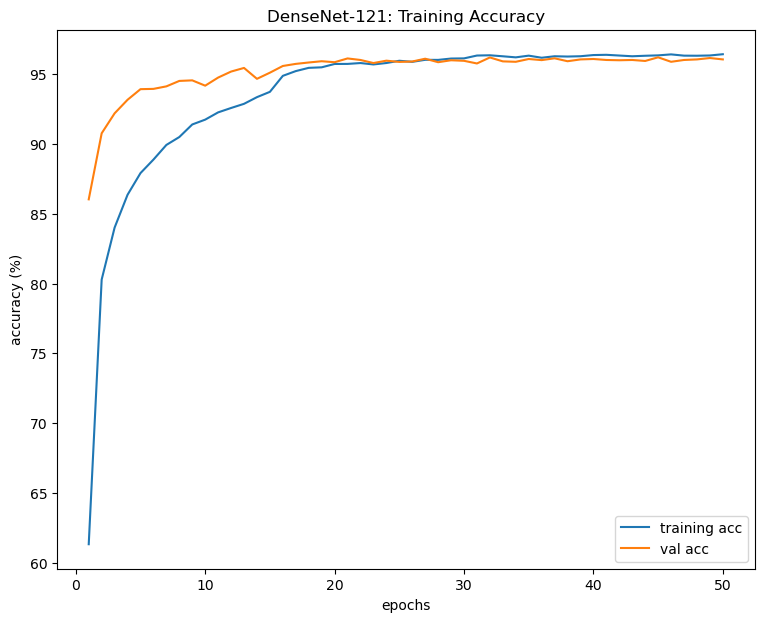

In [22]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("DenseNet-121: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

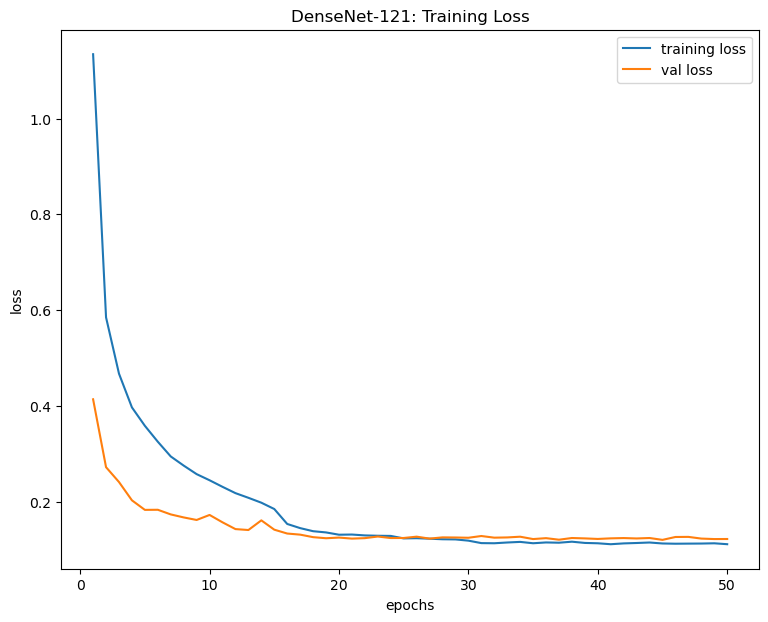

In [23]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("DenseNet-121: Training Loss")
plt.show()

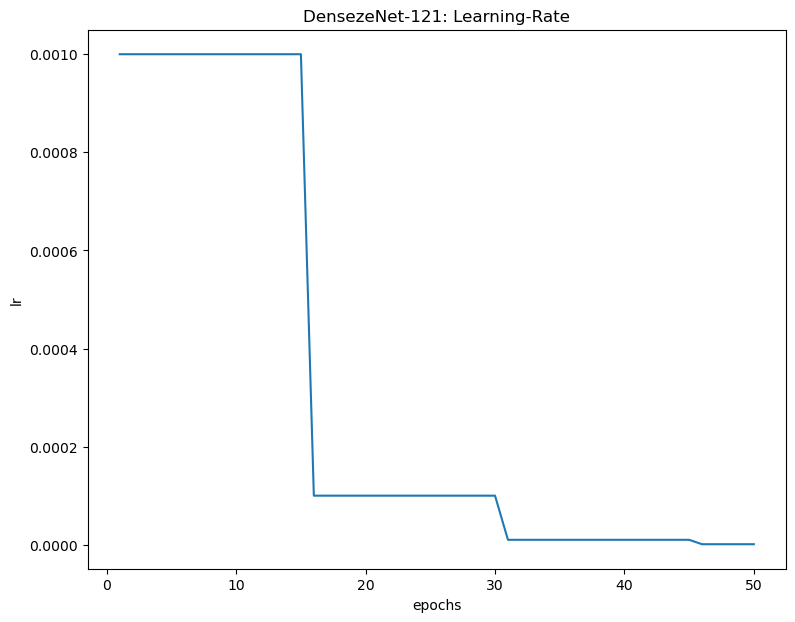

In [24]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("DensezeNet-121: Learning-Rate")
plt.show()